#  Import Statements

In [51]:
import pandas as pd
import sklearn
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df = pd.read_csv('data/data.csv')
cpi = pd.read_csv('data/cpi.csv')
df.head()

,FCID,BookingID,BCreatedDateAEST,BTicketID,BTicketType,TaskName,IsCustomService,IsCustomRepair,PriceIncGSTRaw,VYMM,VMakeModel,VMake,VYear,BShopID,BShopPostcode,BShopState,BShopRegionName,BShopRegionClass
0,1,463259,17/06/2021,708763,Capped,Capped Price - 30K,0,0,180.00,2019 TOYOTA COROLLA,TOYOTA COROLLA,TOYOTA,2019,17885,4102,QLD,Brisbane,1
1,2,1360052,11/01/2024,2122072,Capped,Capped Price - 50K,0,0,315.90,2021 MAZDA CX-5,MAZDA CX-5,MAZDA,2021,17739,2285,NSW,Lake Macquarie,2
2,1,1058706,19/10/2022,1633633,Repair,Replace Wiper Blades,0,0,120.00,2020 SKODA KAROQ,SKODA KAROQ,SKODA,2020,19138,3192,VIC,Melbourne,1
3,2,1078043,11/11/2022,1664447,Logbook,Logbook - 60K / 48m,0,0,462.10,2018 MITSUBISHI ASX,MITSUBISHI ASX,MITSUBISHI,2018,17667,2170,NSW,Sydney,1
4,2,1868175,30/07/2024,3101426,Capped,Capped Price - 30K,0,0,359.21,2020 MAZDA 3,MAZDA 3,MAZDA,2020,17410,3041,VIC,Melbourne,1


# Preprocessing
## What needs to be done?
- Price adjusted for inflation
- one hot encoding?
- train, val, test split
- Visualise data distributions
- Visualise interclass correlation

In [27]:
# Price adjustment for inflation
df['BCreatedDateAEST'] = pd.to_datetime(df['BCreatedDateAEST']);
df['Quarter'] = df['BCreatedDateAEST'].dt.to_period('Q');
cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');
base_cpi = cpi['CPI'].iloc[-1]

/tmp/ipykernel_715/1965790900.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['BCreatedDateAEST'] = pd.to_datetime(df['BCreatedDateAEST']);
/tmp/ipykernel_715/1965790900.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');


In [28]:
merged_df = df.merge(cpi, on='Quarter');
#Round to two decimal places to remain consistent with the existing data
merged_df['adjusted_price'] = round(merged_df['PriceIncGSTRaw'] * (base_cpi / merged_df['CPI']), 2)

In [29]:

pd.set_option('display.max_columns', None)

merged_df.head()

pd.reset_option('display.max_columns')

## Encoding Categoricals

In [30]:
# First extract the number of unique categories (determine cardinality)
# With the cardinality, we can evaluate for which is the most suitable encoding method.

ticketTypeCategories = merged_df['BTicketType'].nunique()
print(f"BTicketType has {ticketTypeCategories} categories") #7

taskNameCategories = merged_df['TaskName'].nunique()
print(f"TaskName has {taskNameCategories} categories") #2721

VYMMCategories = merged_df['VYMM'].nunique()
print(f"VYMM has {VYMMCategories} categories") #5192

VMakeCategories = merged_df['VMake'].nunique()
print(f"VMake has {VMakeCategories} categories") # 360

BShopStateCategories = merged_df['BShopState'].nunique()
print(f"BShopState has {BShopStateCategories} categories") # 8

BShopRegionNameCategories = merged_df['BShopRegionName'].nunique()
print(f"BShopRegionName has {BShopRegionNameCategories} categories") # 119

# Results show that ticketType and BShop state have low cardinality, remaining predictors have high cardinality


BTicketType has 7 categories
TaskName has 2721 categories
VYMM has 5192 categories
VMake has 360 categories
BShopState has 8 categories
BShopRegionName has 119 categories


In [36]:
#Splitting data (Features are what Theo originally encoded)
train_X = merged_df.loc[1:201, ['TaskName', 'VYMM', "VMake", 'BTicketType', 'BShopState', 'BShopRegionName']]
train_Y = merged_df.loc[1:201, 'adjusted_price']

val_X = merged_df.loc[201:226, ['TaskName', 'VYMM', "VMake", 'BTicketType', 'BShopState', 'BShopRegionName']]
val_Y = merged_df.loc[201:226, 'adjusted_price']

test_X = merged_df.loc[226:251, ['TaskName', 'VYMM', "VMake", 'BTicketType', 'BShopState', 'BShopRegionName']]
test_Y = merged_df.loc[226:251, 'adjusted_price']

print(train_X.columns)
print(val_X.columns)
print(test_X.columns)

Index(['TaskName', 'VYMM', 'VMake', 'BTicketType', 'BShopState',
       'BShopRegionName'],
      dtype='object')
Index(['TaskName', 'VYMM', 'VMake', 'BTicketType', 'BShopState',
       'BShopRegionName'],
      dtype='object')
Index(['TaskName', 'VYMM', 'VMake', 'BTicketType', 'BShopState',
       'BShopRegionName'],
      dtype='object')


In [ ]:
#Binary Encodes Task name, VYMM, VMake and Shop region name
binary_encoder = ce.BinaryEncoder(cols=['TaskName', 'VYMM', 'VMake', 'BShopRegionName'])
Binary_train_X = binary_encoder.fit_transform(train_X)
Binary_val_X = binary_encoder.transform(val_X)
Binary_test_X = binary_encoder.transform(test_X)
print("After Binary Encoding (train_X columns):", Binary_train_X.columns)

#One Hot Encodes ticket type and shop state
onehot_encoder = ce.OneHotEncoder(cols=['BTicketType', 'BShopState'])
Encoded_train_X = onehot_encoder.fit_transform(Binary_train_X)
Encoded_val_X = onehot_encoder.transform(Binary_val_X)
Encoded_test_X = onehot_encoder.transform(Binary_test_X)
print("After OneHot Encoding (train_X columns):", Encoded_train_X.columns)

#Encoded_train_X.head()
#Encoded_val_X.head()
#Encoded_test_X.head()

#When data is split, ensure that fit is ONLY applied to the train dataset, then proceed to transform both train and test.

After Binary Encoding (train_X columns): Index(['TaskName_0', 'TaskName_1', 'TaskName_2', 'TaskName_3', 'TaskName_4',
       'TaskName_5', 'TaskName_6', 'VYMM_0', 'VYMM_1', 'VYMM_2', 'VYMM_3',
       'VYMM_4', 'VYMM_5', 'VYMM_6', 'VYMM_7', 'VMake_0', 'VMake_1', 'VMake_2',
       'VMake_3', 'VMake_4', 'BTicketType', 'BShopState', 'BShopRegionName_0',
       'BShopRegionName_1', 'BShopRegionName_2', 'BShopRegionName_3',
       'BShopRegionName_4', 'BShopRegionName_5'],
      dtype='object')
After OneHot Encoding (train_X columns): Index(['TaskName_0', 'TaskName_1', 'TaskName_2', 'TaskName_3', 'TaskName_4',
       'TaskName_5', 'TaskName_6', 'VYMM_0', 'VYMM_1', 'VYMM_2', 'VYMM_3',
       'VYMM_4', 'VYMM_5', 'VYMM_6', 'VYMM_7', 'VMake_0', 'VMake_1', 'VMake_2',
       'VMake_3', 'VMake_4', 'BTicketType_1', 'BTicketType_2', 'BTicketType_3',
       'BTicketType_4', 'BTicketType_5', 'BTicketType_6', 'BShopState_1',
       'BShopState_2', 'BShopState_3', 'BShopState_4', 'BShopState_5',
       '

,TaskName_0,TaskName_1,TaskName_2,TaskName_3,TaskName_4,TaskName_5,TaskName_6,VYMM_0,VYMM_1,VYMM_2,...,BShopState_5,BShopState_6,BShopState_7,BShopState_8,BShopRegionName_0,BShopRegionName_1,BShopRegionName_2,BShopRegionName_3,BShopRegionName_4,BShopRegionName_5
201,0,0,0,0,1,0,1,1,0,0,...,0,0,0,0,1,1,0,0,0,0
202,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
203,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
204,1,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
205,0,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,1,0,1,0,1


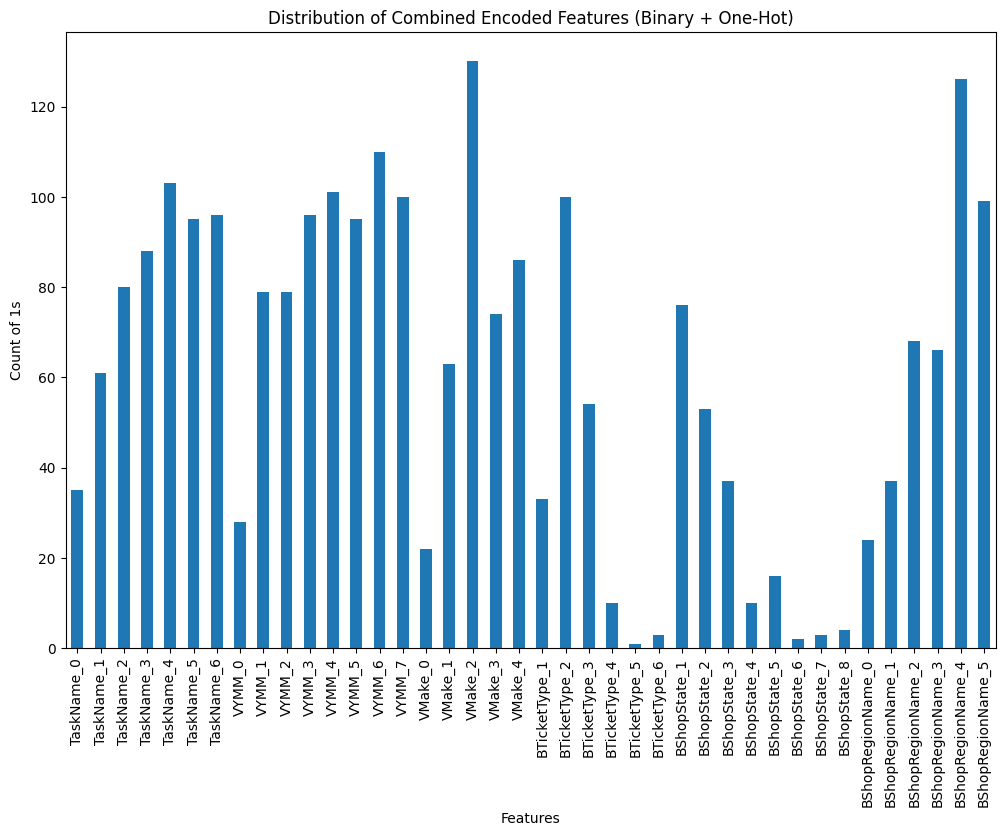

In [55]:
Encoded_train_X.sum().plot(kind='bar', figsize=(12, 8))
plt.title('Distribution of Combined Encoded Features (Binary + One-Hot)')
plt.xlabel('Features')
plt.ylabel('Count of 1s')
plt.show()